# Probabilistic Modeling

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tensorchiefs/dlwbl_eth25/blob/master/notebooks/02_custom_loss.ipynb)

### Learning Objectives
In this notebook, you will learn how to implement a custom loss function using Keras and Pytorch. We will use a simple fcNN model to do probabilistic regression.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
# Set Keras backend to PyTorch
os.environ["KERAS_BACKEND"] = "torch" # Before importing Keras!

import numpy as np
from keras import layers, Input, Model
from keras.optimizers import Adam
import torch
from torch.distributions import Normal
import time


# Print versions
import keras
print(f"Keras version: {keras.__version__}")
print(f"Backend: {keras.backend.backend()}")
print(f"torch version: {torch.__version__}")


Keras version: 3.9.2
Backend: torch
torch version: 2.6.0+cu126


### Generation and visualization of some  data

In [2]:
### Settings
np.random.seed(42)
N_train = 1000
N_validation = 1000 # Number of validation samples (here quite high)
#p_outlier = 0 # Proportion of outliers

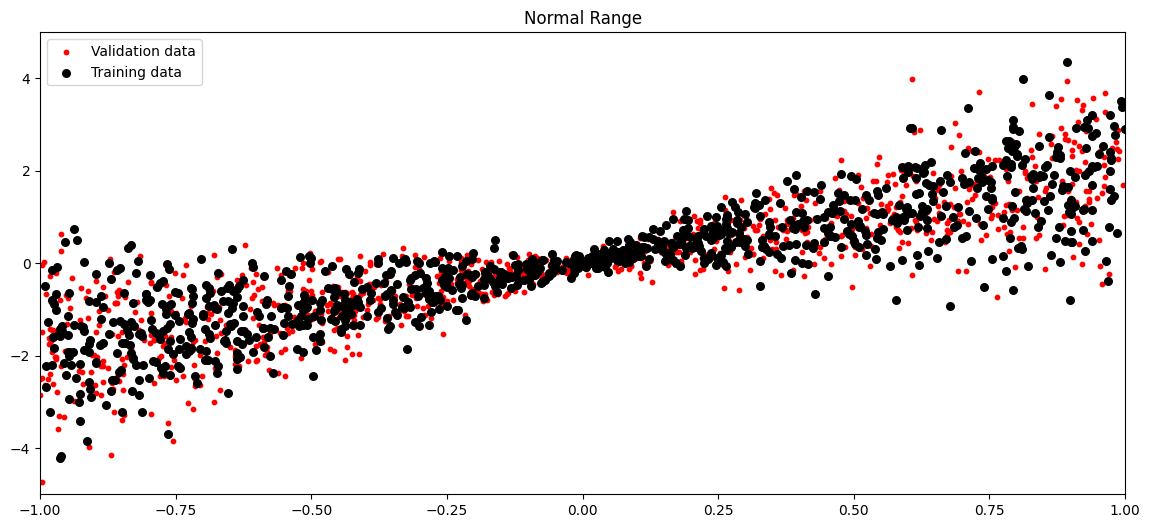

In [3]:
def dgp(N=1000):
    x = np.random.uniform(-1, 1, (N, 1)).astype(np.float32)
    y = (2 * x + 0.1 * np.random.normal(0, 10 * np.abs(x) + 1, (N, 1))).astype(np.float32)
    return x, y

# Generate training data with outliers conditionally
x_train, y_train = dgp(N=N_train)
# Generate validation data with outliers conditionally
x_val, y_val = dgp(N=N_validation)

# Plot the training and validation data on the first subplot
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 6))
ax1.scatter(x_val, y_val, color="red", label="Validation data", s=10)
ax1.scatter(x_train, y_train, color="black", label="Training data", s=30)
ax1.legend()
ax1.set_title("Normal Range")
ax1.set_xlim(-1, 1)
ax1.set_ylim(-5, 5)
plt.show()

### 1. Define a NN-model

Define a NN-model with as many outputs nodes, as we have parameters of the outcome distribution
Here we use as outcome distribution a Gaussian so we need two outputs.

In [4]:
# Define the model
inputs = Input(shape=(1,))
hidden = layers.Dense(10, activation="sigmoid")(inputs)
# task: put here 2 more hidden layers with 100 and 10 neurons each
# you can compare to solution code in task at the end of this notebook
outputs = layers.Dense(2)(hidden)  # <--- Outputs mean and log(sd)
model = Model(inputs=inputs, outputs=outputs)

### 2. 🔗 Link the outputs of the NN to the parameters of the outcome distribution

In [5]:
# Wrapper function to convert model output to a PyTorch Normal distribution
@staticmethod
def output_to_distribution(output):
    mean = output[:, 0:1]   # Gets the first column while keeping dimensions (like output[, 1, drop=FALSE] in R)
    log_sd = output[:, 1:2] # Gets the second column while keeping dimensions
    scale = torch.exp(log_sd) # Inverse link function to ensure positive scale
    return Normal(loc=mean, scale=scale)

### 3. Define NLL


In [15]:
# Custom Negative Log-Likelihood Loss
def negative_log_likelihood(y_true, output):
    dist = output_to_distribution(output)
    return -dist.log_prob(torch.tensor(y_true)).mean()

In [16]:
# Compile the model
# from here on you need to run the code if you have changed the NN architecture
model.compile(optimizer="adam", loss=negative_log_likelihood)

In [17]:
# Print prediction on untrained model (5 Datapoints)
print(f'Prediction on untrained model (5 Datapoints)\n {model.predict(x_train[0:5])}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Prediction on untrained model (5 Datapoints)
 [[ 1.1679696  -0.24685259]
 [ 1.1663642  -0.24223441]
 [ 1.166969   -0.24397588]
 [ 1.1673415  -0.24504854]
 [ 1.1685774  -0.24859127]]


### Training

In [18]:
# Train the model and measure timing
epochs = 100
start_time = time.time()
hist = model.fit(x_train, y_train, epochs=epochs, batch_size=32, validation_data=(x_val, y_val), verbose=0)
torch_training_time = time.time() - start_time

print(f"Torch Training Time: {torch_training_time:.2f} seconds")

C:\Users\miche\AppData\Local\Temp\ipykernel_32940\3450838093.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -dist.log_prob(torch.tensor(y_true)).mean()


Torch Training Time: 29.95 seconds


### Use the trained NN to predict test data

In [11]:
# Predict the distribution
x_test = np.linspace(-1., 1., 100).reshape(-1, 1)
dist = output_to_distribution(model(x_test))

# Use the distribution
samples = dist.sample((5,))  # Draw 5 samples
print("Torch Samples:", samples.shape)

log_p = dist.log_prob(torch.tensor(0.1)).cpu().detach().numpy()
log_p.shape

Torch Samples: torch.Size([5, 100, 1])


(100, 1)

### Plotting the results and Loss


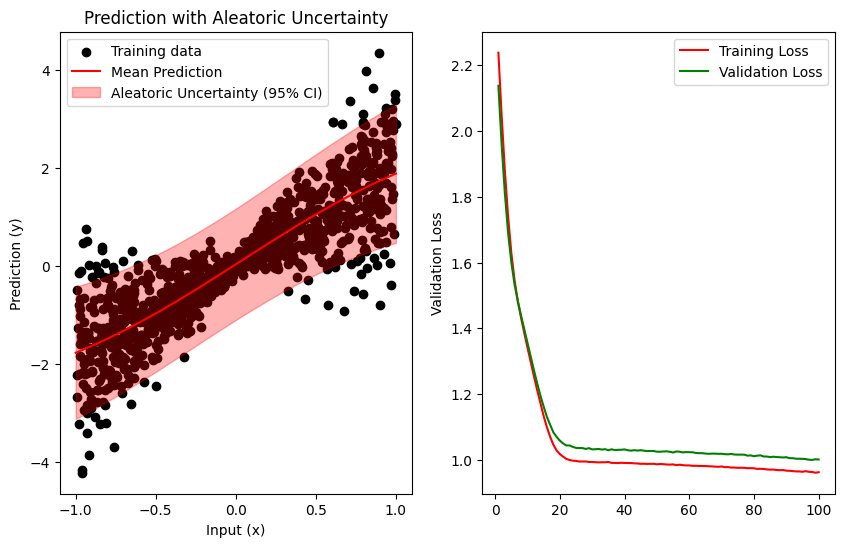

In [13]:
training_loss = hist.history['loss']
validation_loss = hist.history['val_loss']


# Compute 5% and 95% quantiles directly
mean = dist.mean.cpu().detach().numpy().squeeze() # Pytorch, löst die Daten aus dem Tensor 
quantile_5 = dist.icdf(torch.tensor(0.025)).cpu().detach().numpy() # Pytorch. Sorgt dafür, dass die Quantile in der richtigen Form sind
quantile_95 = dist.icdf(torch.tensor(0.975)).cpu().detach().numpy() # Pytorch. Sorgt dafür, dass die Quantile in der richtigen Form sind

# Extract loss values from the training history
loss_values = hist.history['loss']
epochs = range(1, len(loss_values) + 1)

# Visualisierung
import matplotlib.pyplot as plt
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))


# Plot the prediction with uncertainty
ax1.scatter(x_train, y_train, color="black", label="Training data")
ax1.plot(x_test, mean, color="red", label="Mean Prediction")
ax1.fill_between(
    x_test.ravel(),
    quantile_5.squeeze(),  # 5%-Quantil
    quantile_95.squeeze(),  # 95%-Quantil
    color="red",
    alpha=0.3,
    label="Aleatoric Uncertainty (95% CI)"
)
ax1.set_xlabel("Input (x)")
ax1.set_ylabel("Prediction (y)")
ax1.legend(loc="upper left")
ax1.set_title("Prediction with Aleatoric Uncertainty")

# Create a secondary y-axis for the validation loss curve
ax2.plot(epochs, training_loss, color="red", label="Training Loss")
ax2.plot(epochs, validation_loss, color="green", label="Validation Loss")
ax2.set_ylabel("Validation Loss")
ax2.legend(loc="upper right")

plt.show()

### 🔧 **YOUR TASK:**

- Add more hidden layers, what do you observe?


### 🔑 **Solution:**

In [14]:
# @title Possible Network { display-mode: "form" }


# Define the model
inputs = Input(shape=(1,))
hidden = layers.Dense(10, activation="sigmoid")(inputs)
hidden = layers.Dense(100, activation="sigmoid")(hidden)
hidden = layers.Dense(10, activation="sigmoid")(hidden)
outputs = layers.Dense(2)(hidden)  # <--- Outputs mean and log(sd)
model = Model(inputs=inputs, outputs=outputs)

In [24]:
# Train the model and measure timing
epochs = 300
start_time = time.time()
hist = model.fit(x_train, y_train,
                 epochs=epochs,
                 batch_size=32,
                 validation_data=(x_val, y_val),
                 verbose=1)
torch_training_time = time.time() - start_time

print(f"Torch Training Time: {torch_training_time:.2f} seconds")

Epoch 1/300
27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7807

C:\Users\miche\AppData\Local\Temp\ipykernel_32940\3450838093.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -dist.log_prob(torch.tensor(y_true)).mean()


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7777 - val_loss: 0.8098
Epoch 2/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7400 - val_loss: 0.8227
Epoch 3/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7816 - val_loss: 0.8086
Epoch 4/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7082 - val_loss: 0.8038
Epoch 5/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7688 - val_loss: 0.8148
Epoch 6/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7143 - val_loss: 0.8097
Epoch 7/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7516 - val_loss: 0.8061
Epoch 8/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7628 - val_loss: 0.7982
Epoch 9/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7135 - val_loss: 0.7982
Epoch 10/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7667 - val_loss: 0.8008
Epoch 11/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7230 - val_loss: 0.8004
Epoch 12/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6945 

In [25]:
# Predict the distribution
x_test = np.linspace(-1., 1., 100).reshape(-1, 1)
dist = output_to_distribution(model(x_test))

# Use the distribution
samples = dist.sample((5,))  # Draw 5 samples
print("Torch Samples:", samples.shape)

log_p = dist.log_prob(torch.tensor(0.1)).cpu().detach().numpy()
log_p.shape

Torch Samples: torch.Size([5, 100, 1])


(100, 1)

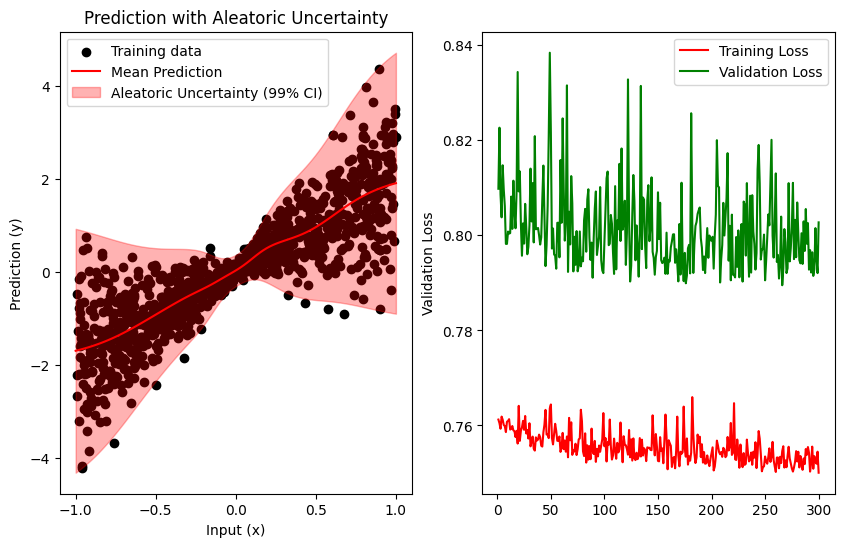

In [27]:
training_loss = hist.history['loss']
validation_loss = hist.history['val_loss']


# Compute 5% and 95% quantiles directly
mean = dist.mean.cpu().detach().numpy().squeeze() # Pytorch, löst die Daten aus dem Tensor 
quantile_5 = dist.icdf(torch.tensor(0.005)).cpu().detach().numpy() # Pytorch. Sorgt dafür, dass die Quantile in der richtigen Form sind
quantile_95 = dist.icdf(torch.tensor(0.995)).cpu().detach().numpy() # Pytorch. Sorgt dafür, dass die Quantile in der richtigen Form sind

# Extract loss values from the training history
loss_values = hist.history['loss']
epochs = range(1, len(loss_values) + 1)

# Visualisierung
import matplotlib.pyplot as plt
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))


# Plot the prediction with uncertainty
ax1.scatter(x_train, y_train, color="black", label="Training data")
ax1.plot(x_test, mean, color="red", label="Mean Prediction")
ax1.fill_between(
    x_test.ravel(),
    quantile_5.squeeze(),  # 5%-Quantil
    quantile_95.squeeze(),  # 95%-Quantil
    color="red",
    alpha=0.3,
    label="Aleatoric Uncertainty (99% CI)"
)
ax1.set_xlabel("Input (x)")
ax1.set_ylabel("Prediction (y)")
ax1.legend(loc="upper left")
ax1.set_title("Prediction with Aleatoric Uncertainty")

# Create a secondary y-axis for the validation loss curve
ax2.plot(epochs, training_loss, color="red", label="Training Loss")
ax2.plot(epochs, validation_loss, color="green", label="Validation Loss")
ax2.set_ylabel("Validation Loss")
ax2.legend(loc="upper right")

plt.show()